In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from natsort import natsorted
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/home/whalenlex/.local/share/virtualenvs/jpdf-to-txt-x2aoK0lp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:

# get labels and file paths
file_paths = []
train_img_path = "train_imgs/"
file_paths = os.listdir(train_img_path)

# Sort the files using natural sorting
file_paths = natsorted(file_paths)
print(len(file_paths))


231300


In [4]:
df = pd.read_csv('samples.csv')

In [5]:
df

,string
0,ぁ
1,あ
2,ぃ
3,い
4,ぅ
...,...
231295,脇
231296,惑
231297,枠
231298,湾


In [6]:
df['path'] = file_paths

In [7]:
class_dict = {e:i for i,e in enumerate(df['string'].unique())}

In [8]:
len(class_dict.items())

2313

In [9]:
class_count = len(df['string'].unique())

In [10]:
class_count

2313

In [11]:
df['index'] = df['string'].apply(lambda x : class_dict[x])

In [12]:
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Define a custom PyTorch dataset
class OCRDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join('train_imgs',self.dataframe.iloc[idx]['path'])
        label = self.dataframe.iloc[idx]['index']

        # Load and preprocess the image
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        if self.transform:
            img = self.transform(img)

        return {
            'imgs':img,
            'labels':label
        }

# Define transformations (adjust as needed)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [43]:
# Create instances of the dataset for training and validation
train_dataset = OCRDataset(train_df, transform=transform)
val_dataset = OCRDataset(val_df, transform=transform)

# Create PyTorch data loaders
batch_size = 625

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
classes = list(df['string'].unique())

In [22]:
int_to_char = {v:k for k,v in class_dict.items()}

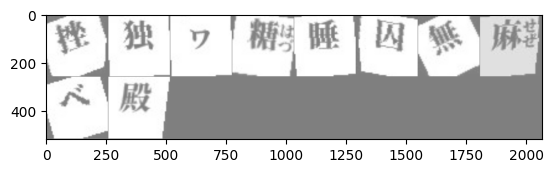

['挫', '独', 'ヮ', '糖', '睡', '囚', '無', '麻', 'べ', '殿']


In [50]:
# 画像の表示
def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 学習画像をランダムに取得
dataiter = iter(train_loader)
item = next(dataiter)
# 画像の表示
imshow(torchvision.utils.make_grid(item['imgs'][:10]))
# バッチサイズの表示
print([int_to_char[i.item()] for i in item['labels'][:10]])

In [51]:
item['imgs'].shape

torch.Size([100, 1, 256, 256])

shape: torch.Size([256, 256])
label: 挫


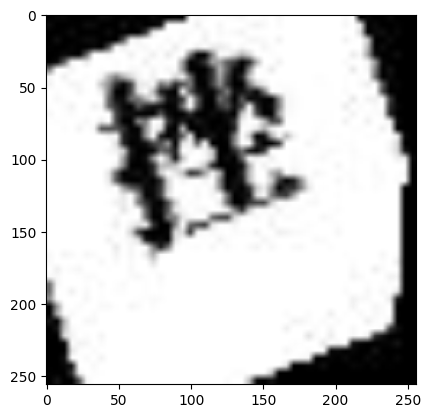

In [52]:
image_data = np.squeeze(item['imgs'][0])
print(f'shape: {image_data.shape}')
print(f'label: {int_to_char[item["labels"][0].item()]}')


plt.imshow(image_data, cmap='gray')
plt.show()


In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1,
                out_channels = 16,
                kernel_size = 5,
                stride = 1,
                padding = 2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 5,
                stride = 1,
                padding = 2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output the number of classes
        self.out = nn.Linear(131072,len(classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0),-1)
        output = self.out(x)

        return output

In [54]:
cnn = Net()

In [55]:
from torch import optim

In [56]:
import torch.cuda as cuda

In [57]:
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn

def train(num_epochs, cnn, train_loader, device):
    cnn = cnn.to(device)
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    cnn.train()
    total_step = len(train_loader)
    accumulated_loss = 0

    for epoch in range(num_epochs):
        for i, e in enumerate(train_loader):
            imgs = e['imgs']
            labels = e['labels']
            b_x = Variable(imgs).to(device)
            b_y = Variable(labels).to(device)

            output = cnn(b_x)

            loss = loss_fn(output, b_y)

            # clear grads
            optimizer.zero_grad()
            
            # backprop
            loss.backward()

            # apply grads
            optimizer.step()
        print(f'e: {epoch}, l: {loss}')


In [59]:
num_epochs = 100

In [60]:
train(num_epochs,cnn,train_loader,device)

e: 0, l: 7.747489929199219
e: 1, l: 7.749396324157715
e: 2, l: 1.566225290298462
e: 3, l: 0.2937198281288147
e: 4, l: 0.23380020260810852
e: 5, l: 0.04708519205451012
e: 6, l: 0.0009473104728385806
e: 7, l: 0.00011301104677841067
e: 8, l: 2.0205550299579045e-06
e: 9, l: 2.5662458938313648e-05
e: 10, l: 0.0002716609451454133
e: 11, l: 0.00040066559449769557
e: 12, l: 3.513821866363287e-05
e: 13, l: 1.0835194188985042e-05
e: 14, l: 1.6420787005699822e-06
e: 15, l: 4.976947138857213e-07
e: 16, l: 0.0
e: 17, l: 3.576278118089249e-08
e: 18, l: 3.8146831116137037e-07
e: 19, l: 2.503386156149645e-07
e: 20, l: 2.9802320611338473e-09
e: 21, l: 2.2112524220574414e-06
e: 22, l: 0.0
e: 23, l: 5.960464122267695e-09
e: 24, l: 2.2270360204856843e-05
e: 25, l: 0.0
e: 26, l: 1.4901156752955558e-08
e: 27, l: 2.9802320611338473e-09
e: 28, l: 0.0
e: 29, l: 0.0
e: 30, l: 0.0
e: 31, l: 0.0
e: 32, l: 5.960463678178485e-09
e: 33, l: 1.2218922051943082e-07
e: 34, l: 2.0861621763401672e-08
e: 35, l: 6.973695576

In [81]:
def test(cnn,val_loader,device):
    # Test the model
    avg = 0
    count = 0
    cnn = cnn.to(device)
    cnn.eval()    

    with torch.no_grad():
        for e in val_loader:
            imgs = e['imgs']
            labels = e['labels']
            imgs = imgs.to(device)
            labels = labels.to(device)
            test_output = cnn(imgs)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            avg += accuracy
            count += 1
        avg = avg / count
    print(f'avg accuracy: {avg}')
    

In [82]:
test(cnn,val_loader,device)

avg accuracy: 0.8524478041756661


In [83]:
torch.save(cnn.state_dict(),'ocr.pth')

In [16]:
cnn = Net()
state_dict = torch.load('ocr.pth')
cnn.load_state_dict(state_dict)
cnn = cnn.to(device)

In [44]:
sample = next(iter(val_loader))
imgs = sample['imgs'].to(device)
labels = sample['labels'].to(device)

In [45]:
len(imgs)

625

In [40]:
test_output = cnn(imgs)
pred_y = torch.max(test_output, 1)[1].data.cpu().numpy().squeeze()
print(f'Prediction number: {pred_y}')
len(pred_y)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [46]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np

# Assuming len(pred_y) and len(sample_imgs) are both 100 (10x10 grid)
grid_size = 10
font_path = "fonts/NotoSerifJP/NotoSerifJP-Black.otf"  # Replace with the path to your TTF font file
font_size = 100
font_color = (255, 0, 0)  # RGB color, replace with your desired color
font = ImageFont.truetype(font_path, font_size)
grid_size = 25
font_size = 20  # Adjust as needed
fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))

for i in range(grid_size):
    for j in range(grid_size):
        index = i * grid_size + j
        pred_num, img = pred_y[index],imgs[index]

        img_array = np.squeeze(img.cpu().numpy())
        img_array_rgb = np.stack((img_array,) * 3, axis=-1)
        img_array_rgb = (img_array_rgb * 255).astype(np.uint8)

        axes[i, j].imshow(img_array_rgb)
        axes[i, j].axis('off')

        japanese_prediction = int_to_char[pred_num]

        img_pil = Image.fromarray(img_array_rgb)
        draw = ImageDraw.Draw(img_pil)

        text_position = (5, 5)  # Adjust as needed
        draw.text(text_position, f'{japanese_prediction}', fill=font_color, font=font)

        axes[i, j].imshow(np.array(img_pil))

plt.tight_layout()  # Adjust layout
plt.savefig('predictions.png')
plt.show()

IndexError: index 100 is out of bounds for axis 0 with size 100

Error in callback <function flush_figures at 0x7efb30946c20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 